## Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score

from imblearn.over_sampling import (
    SMOTE, BorderlineSMOTE, ADASYN, RandomOverSampler, SVMSMOTE
)
from imblearn.under_sampling import (
    RandomUnderSampler, TomekLinks, EditedNearestNeighbours,
    NearMiss, CondensedNearestNeighbour, ClusterCentroids,
    InstanceHardnessThreshold, OneSidedSelection, NeighbourhoodCleaningRule
)
from imblearn.combine import SMOTETomek, SMOTEENN

from pycaret.classification import *
from tqdm.notebook import tqdm
import os

import matplotlib.pyplot as plt

## Objetivo

Conforme informado no Readme do projeto, **o objetivo deste notebook é obter AUCs superiores aos obtidos em aula para os dados de teste, fazendo uso do pycaret para o machine learning.**

Cabe termos por referência os resultados obtidos pelo professor *em dados de treino* no notebook aqui salvo como Case_Ifood_Pycaret:

In [2]:
first_results = pd.read_csv('pycaret_first_results.csv')
first_results


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
0,Ridge Classifier,0.8121,0.9005,0.8099,0.4380,0.5669,0.4613,0.4976,0.018
1,Linear Discriminant Analysis,0.8128,0.9004,0.8099,0.4389,0.5677,0.4624,0.4985,0.019
2,Gradient Boosting Classifier,0.8741,0.8916,0.4478,0.6165,0.5155,0.4455,0.4548,0.098
3,Light Gradient Boosting Machine,0.8727,0.8863,0.3802,0.6329,0.4700,0.4034,0.4229,0.125
4,Random Forest Classifier,0.8836,0.8785,0.3802,0.7094,0.4914,0.4333,0.4618,0.048
5,Ada Boost Classifier,0.8632,0.8658,0.5524,0.5535,0.5485,0.4685,0.4711,0.040
6,Extra Trees Classifier,0.8870,0.8536,0.3798,0.7532,0.5003,0.4448,0.4803,0.039
7,Quadratic Discriminant Analysis,0.7641,0.8299,0.6478,0.4101,0.4827,0.3647,0.3804,0.021
8,Logistic Regression,0.7475,0.8114,0.7235,0.3411,0.4625,0.3247,0.3649,0.421
9,Naive Bayes,0.6937,0.7793,0.6785,0.2853,0.4006,0.2396,0.2804,0.020


O Ridge Classifier foi elegido como melhor modelo a partir da validação cruzada do pycaret.

Seu predict nos dados de teste chegou a **0.7679** de AUC. Este será nosso Benchmark.

## Feature Engineering

No mesmo notebook, nós interviemos com o salvamento do train/test split em dois CSVs, aproveitando todos os passos de limpeza de dados feitos pelo professor.

Avaliaremos possibilidades de novos passos em feature engineering nos dados que possam melhorar ainda mais as classificações.

In [3]:
df_train = pd.read_csv('cleansed_df_train.csv')
df_test = pd.read_csv('cleansed_df_test.csv')
df_train.head()

,AcceptedCmp1,AcceptedCmp2,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,Age,Complain,Education,Income,Kidhome,...,MntWines,NumCatalogPurchases,NumDealsPurchases,NumStorePurchases,NumWebPurchases,NumWebVisitsMonth,Recency,Teenhome,Time_Customer,Response
0,0,0,0,0,0,70,0,2n Cycle,62972,0,...,313,4,2,3,7,6,39,1,12.693151,0
1,0,0,0,0,0,65,0,Graduation,62807,0,...,526,3,3,12,5,5,83,1,12.616438,0
2,0,0,0,0,0,50,0,Graduation,76532,1,...,355,5,4,7,9,5,38,1,11.591781,0
3,0,0,0,0,0,39,0,2n Cycle,20491,0,...,5,1,1,2,0,7,16,0,12.213699,0
4,0,0,0,0,1,42,0,Graduation,78687,0,...,817,6,1,8,4,2,13,0,12.676712,1


Segue comentado o método que foi utilizado para obter a Feature 'Age'. Dado que o dataset é de 2014, faz sentido não utilizar o datetime.now().year, que aumenta, em 2025, 11 anos da idade do cliente:

In [4]:
#from datetime import datetime
#ano_atual = datetime.now().year
#df['Age'] = ano_atual - df.Year_Birth
#df.drop('Year_Birth',axis = 1, inplace = True, errors = 'ignore')
#df.head()

df_train['Age'] = df_train['Age'] - 11
df_test['Age'] = df_test['Age'] - 11


Vamos adiantar o One-Hot-Encoding nas colunas objeto, sem chamá-lo adiante no pycaret:

In [5]:
object_cols = df_train.select_dtypes(include='object').columns
object_cols

Index(['Education', 'Marital_Status'], dtype='object')

In [6]:
encoder = OneHotEncoder(drop='first', sparse_output=False)

df_train_encoded = encoder.fit_transform(df_train[object_cols])
df_train_encoded = pd.DataFrame(df_train_encoded, columns=encoder.get_feature_names_out(object_cols))

df_train = pd.concat([df_train.drop(object_cols, axis=1), df_train_encoded], axis=1)

df_test_encoded = encoder.transform(df_test[object_cols])
df_test_encoded = pd.DataFrame(df_test_encoded, columns=encoder.get_feature_names_out(object_cols))

df_test = pd.concat([df_test.drop(object_cols, axis=1), df_test_encoded], axis=1)

print(df_train.columns)
print(df_test.columns)


Index(['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4',
       'AcceptedCmp5', 'Age', 'Complain', 'Income', 'Kidhome',
       'MntFishProducts', 'MntFruits', 'MntGoldProds', 'MntMeatProducts',
       'MntSweetProducts', 'MntWines', 'NumCatalogPurchases',
       'NumDealsPurchases', 'NumStorePurchases', 'NumWebPurchases',
       'NumWebVisitsMonth', 'Recency', 'Teenhome', 'Time_Customer', 'Response',
       'Education_Basic', 'Education_Graduation', 'Education_Master',
       'Education_PhD', 'Marital_Status_Married', 'Marital_Status_Single',
       'Marital_Status_Together', 'Marital_Status_Widow'],
      dtype='object')
Index(['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4',
       'AcceptedCmp5', 'Age', 'Complain', 'Income', 'Kidhome',
       'MntFishProducts', 'MntFruits', 'MntGoldProds', 'MntMeatProducts',
       'MntSweetProducts', 'MntWines', 'NumCatalogPurchases',
       'NumDealsPurchases', 'NumStorePurchases', 'NumWebPurchases',
       'NumWebVisi

In [7]:
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
AcceptedCmp1,2099.0,0.064316,0.245374,0.000000,0.000000,0.000000,0.000000,1.00000
AcceptedCmp2,2099.0,0.013340,0.114752,0.000000,0.000000,0.000000,0.000000,1.00000
AcceptedCmp3,2099.0,0.072892,0.260021,0.000000,0.000000,0.000000,0.000000,1.00000
AcceptedCmp4,2099.0,0.076227,0.265424,0.000000,0.000000,0.000000,0.000000,1.00000
AcceptedCmp5,2099.0,0.074798,0.263127,0.000000,0.000000,0.000000,0.000000,1.00000
Age,2099.0,45.239638,11.876760,18.000000,37.000000,44.000000,55.000000,121.00000
Complain,2099.0,0.009528,0.097170,0.000000,0.000000,0.000000,0.000000,1.00000
Income,2099.0,52366.100524,25409.369641,1730.000000,35533.500000,51563.000000,68682.000000,666666.00000
Kidhome,2099.0,0.437828,0.536839,0.000000,0.000000,0.000000,1.000000,2.00000
MntFishProducts,2099.0,37.909004,55.006021,0.000000,3.000000,12.000000,50.000000,259.00000


Levando em consideração que o modelo campeão até então foi um Ridge Classifier, o qual é sensível a escalonamento, convirá testar os benefícios do StandardScaler (que é insensível a outliers) mais à frente:

In [8]:
def escalar_colunas_adequadas(df, scaler=None, treinar_scaler=True):
    # Colunas a serem escaladas (com base no describe, evitando binárias ou quase binárias)
    colunas_para_escalar = [
        'Age', 'Income',
        'MntFishProducts', 'MntFruits', 'MntGoldProds',
        'MntMeatProducts', 'MntSweetProducts', 'MntWines',
        'NumCatalogPurchases', 'NumDealsPurchases', 'NumStorePurchases',
        'NumWebPurchases', 'NumWebVisitsMonth', 'Recency'
    ]
    df_escalado = df.copy()
    if scaler is None:
        scaler = StandardScaler()
    if treinar_scaler:
        df_escalado[colunas_para_escalar] = scaler.fit_transform(df_escalado[colunas_para_escalar])
    else:
        df_escalado[colunas_para_escalar] = scaler.transform(df_escalado[colunas_para_escalar])
        
    return df_escalado, scaler

#Usaremos a função mais à frente, mas segue o modo de uso:
df_train_scaled, scaler = escalar_colunas_adequadas(df_train)
# Importante: usamos o scaler já ajustado no treino para transformar o teste para evitar data leakage:
df_test_scaled, _ = escalar_colunas_adequadas(df_test, scaler=scaler, treinar_scaler=False) 
df_train_scaled.describe().T

,count,mean,std,min,25%,50%,75%,max
AcceptedCmp1,2099.0,6.431634e-02,0.245374,0.000000,0.000000,0.000000,0.000000,1.000000
AcceptedCmp2,2099.0,1.333969e-02,0.114752,0.000000,0.000000,0.000000,0.000000,1.000000
AcceptedCmp3,2099.0,7.289185e-02,0.260021,0.000000,0.000000,0.000000,0.000000,1.000000
AcceptedCmp4,2099.0,7.622677e-02,0.265424,0.000000,0.000000,0.000000,0.000000,1.000000
AcceptedCmp5,2099.0,7.479752e-02,0.263127,0.000000,0.000000,0.000000,0.000000,1.000000
Age,2099.0,-1.624871e-16,1.000238,-2.294071,-0.693927,-0.104400,0.821999,6.380395
Complain,2099.0,9.528347e-03,0.097170,0.000000,0.000000,0.000000,0.000000,1.000000
Income,2099.0,3.723664e-17,1.000238,-1.993287,-0.662614,-0.031614,0.642274,24.181878
Kidhome,2099.0,4.378275e-01,0.536839,0.000000,0.000000,0.000000,1.000000,2.000000
MntFishProducts,2099.0,-4.400693e-17,1.000238,-0.689343,-0.634791,-0.471133,0.219865,4.020354


In [9]:
df_train['Response'].value_counts()


Response
0    1783
1     316
Name: count, dtype: int64

Durante o uso pelo professor do pycaret, foi aplicado o método de oversampling SMOTE para rebalancear os dados.

Com interesse de estudo sobre a disputa dados vs. algoritmos, propomos testar diversos outros métodos de balanceamento no processo de treino para entender o quanto essas técnicas podem diversificar o desempenho dos modelos.

Cientes de que o volume de dados aqui utilizado em treino é muito pequeno, não temos a expectativa de diferenças grandes entre a aplicação de uma técnica e outra, a não ser ao compararmos técnicas de undersampling com oversampling. 

Enfatizamos novamente que o código a seguir será aplicado para fins de estudo.

In [10]:
def aplicar_balanceamento(df, resampler_cls, target_col='Response', random_state=42):
    X, y = df.drop(columns=target_col), df[target_col]
    try:
        sampler = resampler_cls(random_state=random_state)
    except TypeError:
        sampler = resampler_cls()
    X_res, y_res = sampler.fit_resample(X, y)
    return pd.concat([pd.DataFrame(X_res, columns=X.columns), pd.Series(y_res, name=target_col)], axis=1)

lista_metodos = [
    ('SMOTE', SMOTE, 'Over'),
    ('Borderline SMOTE', BorderlineSMOTE, 'Over'),
    ('ADASYN', ADASYN, 'Over'),
    ('Random OverSampler', RandomOverSampler, 'Over'),
    ('SVM SMOTE', SVMSMOTE, 'Over'),
    ('Random UnderSampler', RandomUnderSampler, 'Under'),
    ('Tomek Links', TomekLinks, 'Under'),
    ('Edited Nearest Neighbours', EditedNearestNeighbours, 'Under'),
    ('NearMiss', NearMiss, 'Under'),
    ('Condensed Nearest Neighbour', CondensedNearestNeighbour, 'Under'),
    ('Cluster Centroids', ClusterCentroids, 'Under'),
    ('Instance Hardness Threshold', InstanceHardnessThreshold, 'Under'),
    ('SMOTEENN', SMOTEENN, 'Combinado'),
    ('SMOTETomek', SMOTETomek, 'Combinado'),
    ('One-Sided Selection', OneSidedSelection, 'Combinado'),
    ('Neighbourhood Cleaning Rule', NeighbourhoodCleaningRule, 'Combinado'),
]

metodos = {
    nome: (aplicar_balanceamento(df_train, metodo), tipo)
    for nome, metodo, tipo in lista_metodos
}

# DataFrame com estatísticas
df_amostragens = pd.DataFrame([
    {
        'Método': nome,
        'Tipo': tipo,
        'Linhas': df.shape[0],
        'Classe 0': df['Response'].value_counts().get(0, 0),
        'Classe 1': df['Response'].value_counts().get(1, 0)
    }
    for nome, (df, tipo) in metodos.items()
])

print(df_amostragens)


                         Método       Tipo  Linhas  Classe 0  Classe 1
0                         SMOTE       Over    3566      1783      1783
1              Borderline SMOTE       Over    3566      1783      1783
2                        ADASYN       Over    3560      1783      1777
3            Random OverSampler       Over    3566      1783      1783
4                     SVM SMOTE       Over    3566      1783      1783
5           Random UnderSampler      Under     632       316       316
6                   Tomek Links      Under    2008      1692       316
7     Edited Nearest Neighbours      Under    1618      1302       316
8                      NearMiss      Under     632       316       316
9   Condensed Nearest Neighbour      Under     789       473       316
10            Cluster Centroids      Under     632       316       316
11  Instance Hardness Threshold      Under     732       416       316
12                     SMOTEENN  Combinado    2203       907      1296
13    

# Auto ML - PYCARET

Faremos uso do Pycaret para treinamento dos modelos.

Em uma primeira tentativa, buscaremos obter maior AUC em teste com apenas algumas modificações no setup do Pycaret, e a modificação em 'Age' acima.

Faremos inclusive a remoção do método SMOTE para essa tentativa.

In [11]:
s = setup(data = df_train,
          target = 'Response',
          fix_imbalance = False, # Não balanceamos automaticamente aqui, pois o faremos sem o Pycaret
          remove_outliers = True, #Poderíamos ter feito antes para obter melhores balanceamentos em alguns casos, mas manteremos aqui
          #categorical_features = ['Education', 'Marital_Status'], #Também já fizemos isso antes
          session_id = 123,

          normalize=False, #Testaremos fora do Pycaret
          #Vamos experimentar o argumento de remoção de multicolinearidade do Pycaret:
          remove_multicollinearity=True,
          multicollinearity_threshold=0.95,
)



,Description,Value
0,Session id,123
1,Target,Response
2,Target type,Binary
3,Original data shape,"(2099, 32)"
4,Transformed data shape,"(2025, 32)"
5,Transformed train set shape,"(1395, 32)"
6,Transformed test set shape,"(630, 32)"
7,Numeric features,31
8,Preprocess,True
9,Imputation type,simple


In [25]:
models() #Conferindo os modelos disponíveis

,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model._logistic.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors._classification.KNeighborsCl...,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model._stochastic_gradient.SGDC...,True
rbfsvm,SVM - Radial Kernel,sklearn.svm._classes.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessC...,False
mlp,MLP Classifier,sklearn.neural_network._multilayer_perceptron....,False
ridge,Ridge Classifier,sklearn.linear_model._ridge.RidgeClassifier,True


In [ ]:
best_model = compare_models(n_select=20, sort = 'auc', errors = 'raise',turbo=True) #Com turbo=False, rodamos todos os modelos disponíveis
#E com n_select=20, pegamos a lista de todos os 17 modelos rodados, ao invés de apenas o melhor.

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ridge,Ridge Classifier,0.8890,0.8962,0.3617,0.8000,0.4924,0.4404,0.4870,0.0150
lda,Linear Discriminant Analysis,0.8863,0.8956,0.5377,0.6456,0.5833,0.5186,0.5233,0.0150
lightgbm,Light Gradient Boosting Machine,0.8713,0.8839,0.3350,0.6447,0.4327,0.3698,0.3986,0.1100
gbc,Gradient Boosting Classifier,0.8714,0.8719,0.3441,0.6401,0.4428,0.3781,0.4037,0.0440
rf,Random Forest Classifier,0.8604,0.8695,0.1858,0.6267,0.2749,0.2254,0.2793,0.0370
et,Extra Trees Classifier,0.8741,0.8583,0.2575,0.7409,0.3753,0.3243,0.3831,0.0330
qda,Quadratic Discriminant Analysis,0.7682,0.8457,0.6834,0.4303,0.5110,0.3968,0.4075,0.0150
ada,Ada Boost Classifier,0.8829,0.8205,0.4478,0.6640,0.5260,0.4639,0.4796,0.0250
lr,Logistic Regression,0.8543,0.7964,0.2213,0.5408,0.3123,0.2469,0.2785,0.3830
nb,Naive Bayes,0.7971,0.7792,0.5334,0.3779,0.4414,0.3221,0.3299,0.0150


Semelhantemente ao benchmark deste projeto, nosso treinamento indicou o Ridge Classifier como o melhor modelo na validação cruzada executada pelo pycaret sobre os dados de treino.

Nada obstante algumas de nossas alterações nos dados e no treino que teoricamente melhorariam o desempenho do treinamento, obtivemos um resultado inferior nas AUCs.
Possivelmente, isso se deve à ausência do SMOTE nesta abordagem.

Contudo, temos a hipótese de que nossos resultados nos dados pré-selecionados de teste ainda podem ser superiores.

Note-se que no notebook Case_Ifood_Pycaret, a decisão foi de rodar no dataset de teste apenas o modelo com melhor desempenho na validação cruzada do pycaret, ignorando a possível maior capacidade de generalização nos dados de teste de modelos que tiveram AUCs menores.

Nossa abordagem será diferente. 
Abaixo, definimos uma função para validação no dataset de teste pré-definido no outro notebook de todos os modelos rodados
(alguns trechos não utilizados são pensados para a iteração subsequente que operaremos).
Enfim, testamos em cada um dos modelos sua capacidade de generalização nos dados de teste.



In [ ]:
def avaliar_modelo_teste(modelo, df_test, scaler=None): 
    """
    Avalia um modelo PyCaret nos dados de teste e retorna um dicionário com métricas.

    Parâmetros:
        modelo: modelo treinado (PyCaret)
        df_test: DataFrame com dados de teste (contendo coluna 'Response')
        scaler: scaler usado no treino, se aplicável
        colunas_scaler: colunas usadas no fit do scaler

    Retorna:
        dict com métricas: AUC, Accuracy, Recall, Precision, F1
    """
    df_test_sem_target = df_test.drop(columns=['Response'], errors='ignore').copy()
    y_true = df_test['Response'].values

    # Verifica se é necessário escalar as colunas
    if scaler:  
        df_test_sem_target, _ = escalar_colunas_adequadas(df_test_sem_target, scaler=scaler, treinar_scaler=False)

    # Obtemos os scores para o cálculo da AUC, exceto se o modelo não tiver predict_proba (ex. DummyClassifier):
    try:
        y_labels = modelo.predict(df_test_sem_target)
    except Exception as e:
        print(f"Erro ao prever labels: {e}")
        y_labels = np.zeros_like(y_true)

    try:
        if hasattr(modelo, 'predict_proba'):  
            y_scores = modelo.predict_proba(df_test_sem_target)[:, 1]
        else:
            y_scores = y_labels
    except Exception as e:
        print(f"Erro ao prever scores: {e}")
        y_scores = np.zeros_like(y_true)

    resultado = {
        'Test_AUC': roc_auc_score(y_true, y_scores) if len(np.unique(y_scores)) > 1 else 0,
        'Test_Accuracy': accuracy_score(y_true, y_labels),
        'Test_Recall': recall_score(y_true, y_labels),
        'Test_Precision': precision_score(y_true, y_labels),
        'Test_F1': f1_score(y_true, y_labels)
    }

    return resultado

avaliacoes = []

for modelo in best_model:
    resultado = avaliar_modelo_teste(modelo, df_test)
    resultado['Model'] = str(modelo)
    avaliacoes.append(resultado)

df_avaliacoes = pd.DataFrame(avaliacoes)
df_avaliacoes.sort_values(by='Test_AUC', ascending=False, inplace=True)
display(df_avaliacoes)

,Test_AUC,Test_Accuracy,Test_Recall,Test_Precision,Test_F1,Model
7,0.855283,0.845455,0.357143,0.384615,0.370370,"AdaBoostClassifier(algorithm='SAMME.R', estima..."
2,0.837426,0.845455,0.214286,0.333333,0.260870,"LGBMClassifier(boosting_type='gbdt', class_wei..."
3,0.816592,0.854545,0.142857,0.333333,0.200000,"GradientBoostingClassifier(ccp_alpha=0.0, crit..."
1,0.803199,0.854545,0.357143,0.416667,0.384615,LinearDiscriminantAnalysis(covariance_estimato...
4,0.784226,0.863636,0.071429,0.333333,0.117647,"RandomForestClassifier(bootstrap=True, ccp_alp..."
5,0.771577,0.872727,0.071429,0.500000,0.125000,"ExtraTreesClassifier(bootstrap=False, ccp_alph..."
6,0.763393,0.827273,0.357143,0.333333,0.344828,"QuadraticDiscriminantAnalysis(priors=None, reg..."
9,0.706473,0.790909,0.357143,0.263158,0.303030,"GaussianNB(priors=None, var_smoothing=1e-09)"
11,0.638393,0.800000,0.428571,0.300000,0.352941,"DecisionTreeClassifier(ccp_alpha=0.0, class_we..."
8,0.620908,0.872727,0.071429,0.500000,0.125000,"LogisticRegression(C=1.0, class_weight=None, d..."


Eis que surpreendentemente não apenas a performance do Ridge Classifier caiu bastante relativamente ao treino do notebook mencionado (acreditamos que devido à ausência do SMOTE, mas temos nossas dúvidas e seremos gratos por contribuições com outras hipóteses), mas modelos com AUCs um pouco inferiores na validação cruzada do pycaret demostraram uma generalização incrivelmente mais consistente quando aplicados ao dataset de teste.

Tanto é que com essa simples modificação, desconsiderando o uso de SMOTE, **batemos o benchmark de 0.7679 com a AUC de 0.855283 do AdaBoostClassifier**.

Comprova-se que a prática no notebook anterior de testar a generalização apenas de um modelo levou à perda significativa de informação sobre modelos melhores no dataset de teste pré-definido.

Agora, realizaremos uma varredura mais sistemática: para cada combinação de técnica de balanceamento e decisão de padronizar ou não os dados, treinaremos e comparamos todos os modelos distintos do pycaret com base na métrica AUC. Faremos, assim, a análise combinatória de 2x16x17 treinamentos, considerando padronizar ou não, os dezesseis métodos de balanceamento selecionados e os 17 modelos de classificação disponíveis.

Ao final de cada rodada, avaliaremos todos os modelos no dataset de teste original, salvaremos os modelos, e registraremos suas métricas.

Para maiores análises, convidamos a checar o trained_models.xlsx resultante.
(Lembrando que algumas AUCs serão zeradas devido à natureza dos modelos)

In [18]:
output_dir = 'saved_models'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

resultados_finais = []
model_id_counter = 1

for padronizar in tqdm([0, 1], desc='Padronização (0=Não, 1=Sim)'):
    for nome_metodo, (df_balanceado, tipo_balanceamento) in tqdm(metodos.items(), desc='Métodos de Balanceamento', leave=False):
        scaler = None
        colunas_scaler = None

        # Aplicar padronização se necessário
        if padronizar:
            # Usar a função escalar_colunas_adequadas para a padronização
            colunas_scaler = df_balanceado.select_dtypes(include=['float64', 'int64']).drop(columns='Response', errors='ignore').columns.tolist()
            df_balanceado, scaler = escalar_colunas_adequadas(df_balanceado, scaler=StandardScaler(), treinar_scaler=True)

        try:
            clear_config()
        except:
            pass

        # Setup do PyCaret
        s = setup(data=df_balanceado,
                  target='Response',
                  fix_imbalance=False,
                  remove_outliers=True,
                  normalize=False,
                  remove_multicollinearity=True,
                  multicollinearity_threshold=0.95,
                  session_id=123,
                  verbose=False)  # Adicionando verbose=False para não exibir as tabelas
        
        # Rodar todos os modelos
        modelos_testados = compare_models(n_select=20, sort='auc', errors='raise', turbo=False, verbose=False)

        #Caso removamos o argumento n_select, o retorno não será uma lista, mas um único modelo. Convém então manter este teste:
        if not isinstance(modelos_testados, list):
            modelos_testados = [modelos_testados]

        resultados = pull()

        for i, modelo in enumerate(modelos_testados):
            model_id = model_id_counter
            model_id_counter += 1

            # Preparando o dicionário com os resultados
            linha_resultado = resultados.iloc[i].to_dict()
            linha_resultado['Model ID'] = model_id  
            linha_resultado['Padronizado'] = padronizar
            linha_resultado['Balanceamento'] = nome_metodo
            linha_resultado['Tipo'] = tipo_balanceamento

            # Avaliar modelo nos dados de teste
            resultado_teste = avaliar_modelo_teste(modelo, df_test, scaler=scaler)
            linha_resultado.update(resultado_teste)
            resultados_finais.append(linha_resultado)

            # Salvando o modelo
            model_file_path = os.path.join(output_dir, f"{model_id}")
            save_model(modelo, model_file_path, verbose=False)

            # Salvando a informação do modelo
            model_info = {
                'Model ID': model_id,
                'Nome do Modelo': modelo.__class__.__name__,
                'Método de Balanceamento': nome_metodo,
                'Padronizado': padronizar
            }
            model_str = str(modelo)
            model_info_file = os.path.join(output_dir, f"{model_id}_info.txt")
            with open(model_info_file, 'w') as f:
                for key, value in model_info.items():
                    f.write(f"{key}: {value}\n")
                f.write("\nModelo Detalhado:\n")
                f.write(model_str)

# Criando o DataFrame com os resultados finais
df_resultados_finais = pd.DataFrame(resultados_finais)
df_resultados_finais.to_excel('trained_models.xlsx', index=False)

Padronização (0=Não, 1=Sim):   0%|          | 0/2 [00:00<?, ?it/s]

Métodos de Balanceamento:   0%|          | 0/16 [00:00<?, ?it/s]

Métodos de Balanceamento:   0%|          | 0/16 [00:00<?, ?it/s]

Analisaremos abaixo os modelos segundo seus valores na métrica-alvo para os dados de teste, considerando também os resultados para a validação cruzada do pycaret.

Nossa configuração de Labels o denota, mas convém acentuar que o número 0 (False) ou 1 (True) nas linhas do gráfico com o nome do modelo indicam se houve ou não padronização.

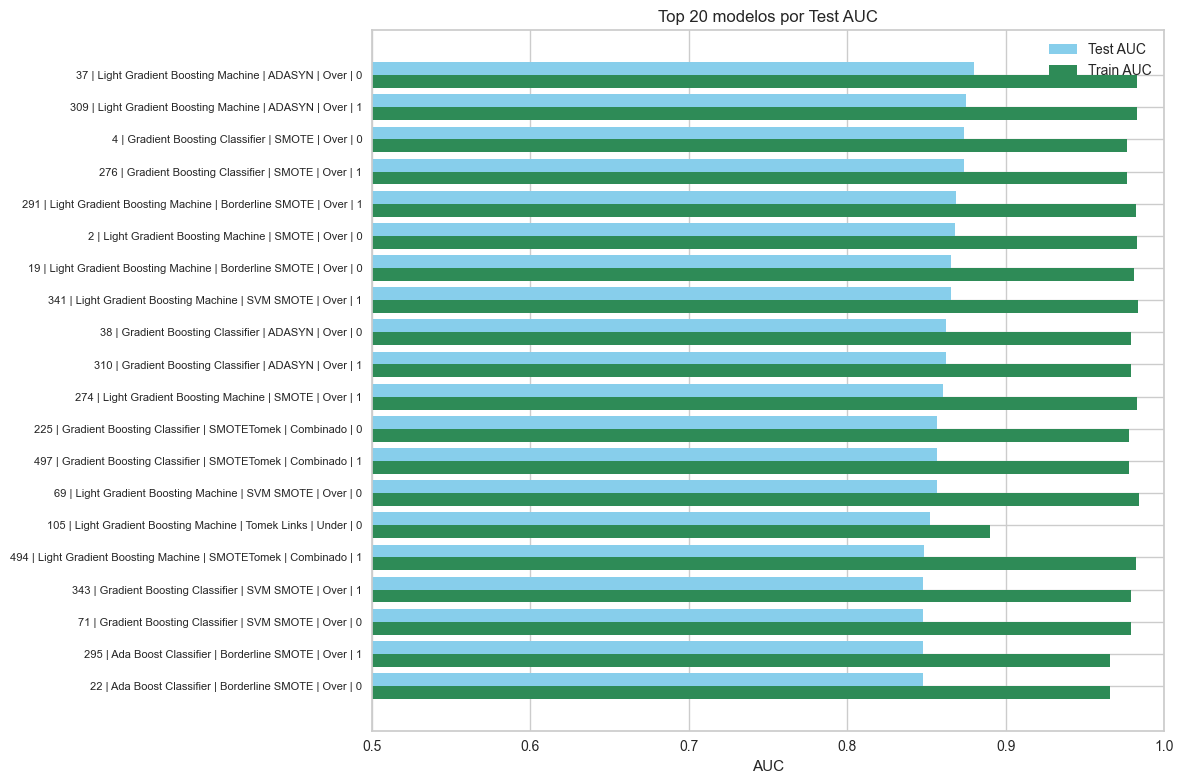

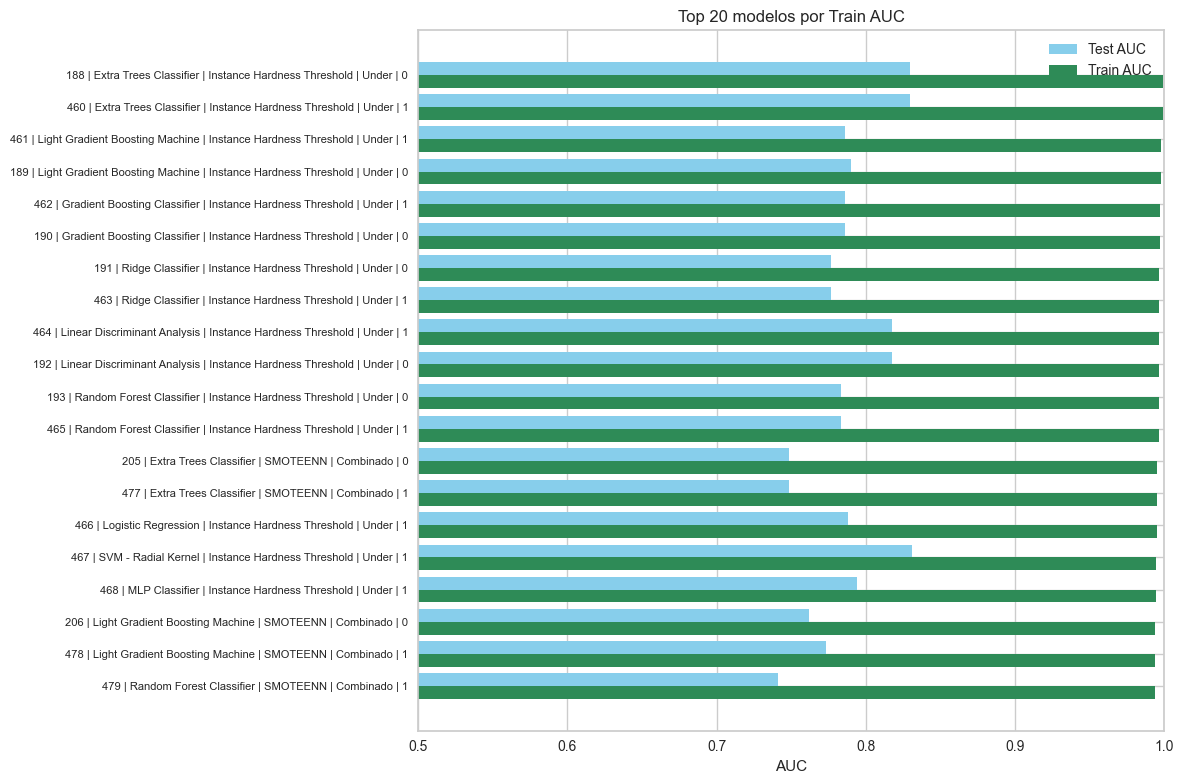


Total de modelos avaliados: 544

🔵 Melhor modelo nos dados de TESTE:
Model ID                                      37
Model            Light Gradient Boosting Machine
Balanceamento                             ADASYN
Tipo                                        Over
Padronizado                                    0
Test_AUC                                0.879836
Name: 36, dtype: object

🟢 Melhor modelo nos dados de TREINO:
Model ID                                 188
Model                 Extra Trees Classifier
Balanceamento    Instance Hardness Threshold
Tipo                                   Under
Padronizado                                0
AUC                                   0.9988
Name: 187, dtype: object


In [24]:
# Criar label combinando as informações desejadas
df_resultados_finais['label'] = (
    df_resultados_finais['Model ID'].astype(str) + ' | ' +
    df_resultados_finais['Model'].astype(str) + ' | ' +
    df_resultados_finais['Balanceamento'].astype(str) + ' | ' +
    df_resultados_finais['Tipo'].astype(str) + ' | ' +
    df_resultados_finais['Padronizado'].astype(str)
)

top_test = df_resultados_finais.sort_values('Test_AUC', ascending=False).head(20)
top_test = top_test.sort_values('Test_AUC')
top_train = df_resultados_finais.sort_values('AUC', ascending=False).head(20)
top_train = top_train.sort_values('AUC')

def plot_top_models(data, title, bar_width=0.4):
    plt.figure(figsize=(12, 8))
    indices = range(len(data))
    plt.barh([i + bar_width/2 for i in indices], data['Test_AUC'], height=bar_width, label='Test AUC', color='#87CEEB')
    plt.barh([i - bar_width/2 for i in indices], data['AUC'], height=bar_width, label='Train AUC', color='#2E8B57')
    plt.yticks(indices, data['label'], fontsize=8)
    plt.xlabel('AUC')
    plt.title(title)
    plt.legend()
    plt.xlim(0.5, 1)
    plt.tight_layout()
    plt.show()

plot_top_models(top_test, 'Top 20 modelos por Test AUC')
plot_top_models(top_train, 'Top 20 modelos por Train AUC')

melhor_teste = df_resultados_finais.loc[df_resultados_finais['Test_AUC'].idxmax()]
melhor_treino = df_resultados_finais.loc[df_resultados_finais['AUC'].idxmax()]

print(f"\nTotal de modelos avaliados: {len(df_resultados_finais)}")
print("\n🔵 Melhor modelo nos dados de TESTE:")
print(melhor_teste[['Model ID', 'Model', 'Balanceamento', 'Tipo', 'Padronizado', 'Test_AUC']])
print("\n🟢 Melhor modelo nos dados de TREINO:")
print(melhor_treino[['Model ID', 'Model', 'Balanceamento', 'Tipo', 'Padronizado', 'AUC']])


## Análise Final

Muitos insights podem ser extraídos de nossa iteração experimental.

Primeiro, considerando a métrica-alvo, **obtivemos nossos melhores resultados na interação do LightGBM com os dados transformados por overbalancing com ADASYN, chegando a 0.879836 de AUC nos dados de Teste.**

É digno de nota que ele sem a padronização obteve resultados ligeiramente superiores ao treinamento com padronização, devido à sua insensibilidade ao escalonamento, por ser baseado em árvores.
Verificamos, aliás, que na maioria dos casos a padronização não foi útil dado a maioria de modelos pouco sensíveis a escalonamento, embora seja interessante notar que a única aparição da regressão logística no segundo gráfico deve-se muito provavelmente aos dados padronizados desse treinamento.

(Uma observação que convém trazer à tona é que estivemos cientes um pouco tarde do pequeno data leakage *no caso exclusivo dos treinamentos via validação cruzada do pycaret* que criamos ao fazer a padronização por fora do setup do pycaret. Felizmente isso não afetou nossos resultados nas validações no dataset de teste, e em nossa defesa fizemos a padronização por fora do pycaret apenas porque, caso o modelo campeão em teste se beneficiasse da padronização, queríamos poder exportar com facilidade o scaler treinado para a etapa de produção).

Por fim, cabem algumas considerações sobre as iterações dos treinamentos com diferentes métodos de balanceamento.
Somado aos dois gráficos acima, o gráfico a seguir, contendo todos os treinamentos sem padronização do algoritmo considerado campeão, ajudará a ilustrar nosso ponto:

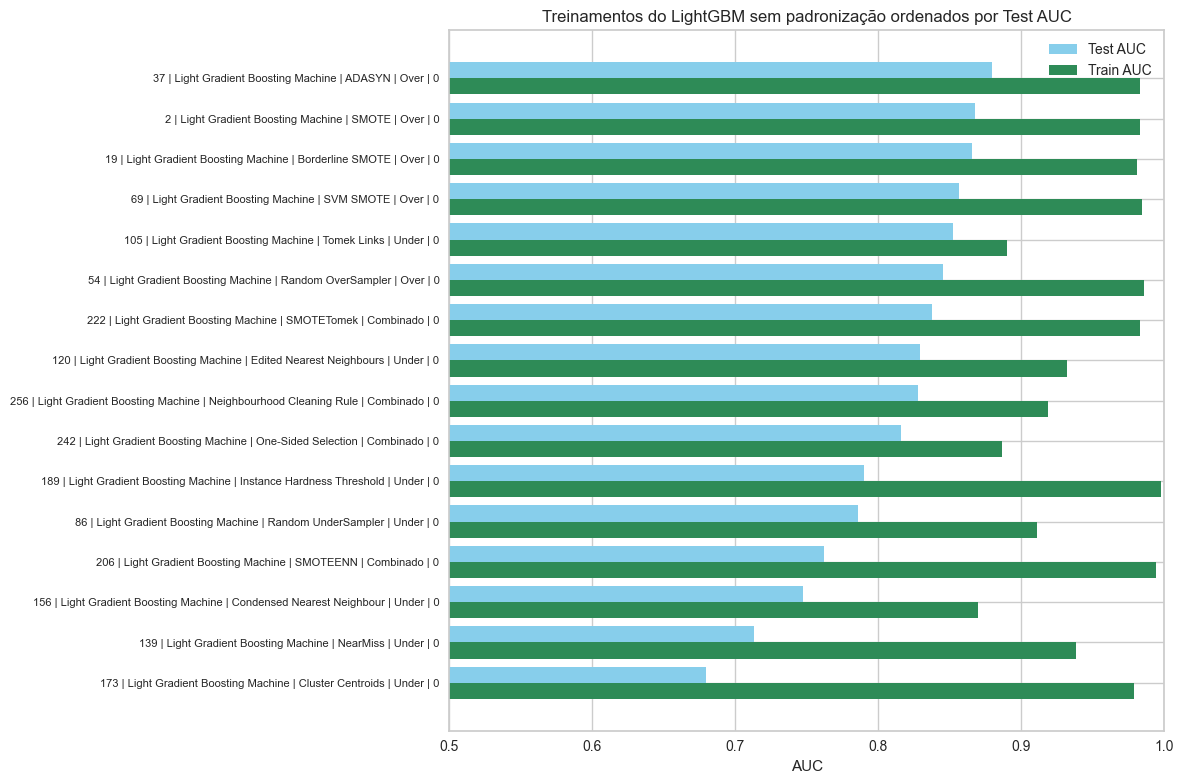

In [34]:
lgbm_nao_padronizados = df_resultados_finais[
    (df_resultados_finais['Model'].str.contains('Light Gradient Boosting Machine') &
    (df_resultados_finais['Padronizado'] == 0))
]

lgbm_nao_padronizados = lgbm_nao_padronizados.sort_values('Test_AUC')

lgbm_nao_padronizados['label'] = (
    lgbm_nao_padronizados['Model ID'].astype(str) + ' | ' +
    lgbm_nao_padronizados['Model'].astype(str) + ' | ' +
    lgbm_nao_padronizados['Balanceamento'].astype(str) + ' | ' +
    lgbm_nao_padronizados['Tipo'].astype(str) + ' | ' +
    lgbm_nao_padronizados['Padronizado'].astype(str)
)

plot_top_models(lgbm_nao_padronizados, 'Treinamentos do LightGBM sem padronização ordenados por Test AUC')


A distribuição inicial dos dados, bastante desbalanceada (com apenas 316 instâncias positivas frente a 1783 negativas) já antecipava o desafio inerente à modelagem.

Não surpreende, portanto, que os métodos de overbalancing, sobretudo ADASYN e SMOTE, tenham consistentemente liderado em performance nos dados de teste, apresentando as maiores AUCs, conforme evidenciam todos os gráficos acima.

Em contraste, os métodos baseados em underbalancing, ainda que por vezes tenham performado muito bem nos dados de treino com validação cruzada, revelaram-se sistematicamente propensos ao overfitting. A discrepância entre AUCs altíssimos no treino e valores por vezes dramáticos de AUC em teste denuncia com clareza o problema: ao reduzir demais o conjunto de dados, a representatividade do espaço amostral se perde, e o modelo se torna excessivamente especializado nos poucos exemplos disponíveis — fenômeno agravado pela própria natureza do LightGBM, que se beneficia fortemente de volume e variabilidade.

Já os métodos combinados (under + over) apresentaram desempenho intermediário, mas com uma robustez interessante, sugerindo um possível espaço de equilíbrio entre complexidade e generalização, embora não tenham superado os métodos puramente baseados em overbalancing nos testes.

Concluímos, assim, que em contextos de desbalanceamento severo, como o observado, os métodos de overbalancing puro — especialmente ADASYN e SMOTE — são os que melhor aliam desempenho preditivo com capacidade de generalização. O uso de underbalancing deve ser feito com extremo cuidado, pois embora possa sugerir bons resultados em validação cruzada interna, frequentemente está associado a uma ilusória confiança modelar que não se sustenta em dados fora da amostra.

Essa constatação nos leva à recomendação prática de priorizar técnicas de oversampling bem calibradas em pipelines futuros, com atenção à sua integração ao fluxo de produção e à preservação da variabilidade do conjunto original. A clareza com que o gráfico final ilustra essa realidade encerra, portanto, nosso experimento com um aprendizado valioso sobre a relação entre balanceamento, complexidade amostral e poder de generalização em modelos supervisionados.

In [22]:
#Opcional: Deletar todos os modelos exceto o melhor:
model_id_to_keep = str(melhor_teste['Model ID'])
files_to_keep = {f'{model_id_to_keep}.pkl', f'{model_id_to_keep}_info.txt'}
for file in os.listdir(output_dir):
    if file not in files_to_keep:
        file_path = os.path.join(output_dir, file)
        os.remove(file_path)